# Prediccion Gasto

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_categorizado = pd.read_csv('movimientos_categorizados.csv')

In [3]:
df_gasto = df_categorizado[df_categorizado['tipo'] == 'gasto'].copy()
gastos_mensuales = df_gasto.groupby(['año_mes', 'categoria'])['importe'].sum().unstack(fill_value=0)
display(gastos_mensuales)

categoria,Compras no esenciales,Facturas,Gastos extraordinarios,Ingreso,Ocio / Suscripciones,Préstamo,Restauración,Supermercado,Transferencia personal,Transporte
año_mes,,,,,,,,,,
2021-09,51.08,0.00,0.00,200.0,4.99,0.00,49.21,0.00,6.00,34.70
2021-10,0.00,0.00,0.00,0.0,0.00,0.00,32.95,0.00,29.90,48.45
2021-11,2.45,164.99,0.00,0.0,29.41,0.00,67.95,17.90,5.00,165.25
2021-12,12.30,143.04,0.00,20.0,4.99,0.00,176.46,157.68,8.05,120.90
2022-01,45.98,143.05,0.00,0.0,28.95,0.00,120.27,48.33,0.00,64.87
2022-02,50.76,166.40,0.00,0.0,32.55,0.00,94.21,124.59,0.00,98.25
2022-03,3.35,275.14,797.03,110.0,13.98,0.00,66.05,80.54,15.50,105.00
2022-04,59.99,275.14,241.39,0.0,20.17,0.00,154.99,47.02,5.00,0.00
2022-05,0.50,156.00,0.00,0.0,20.17,0.00,120.51,101.91,0.00,34.18


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def modelo_naive_media(gastos_mensuales, categoria, n_meses=6, meses_pred=4):
    """
    Modelo Naïve: predice usando la media de los últimos n_meses hasta 2024-12-31.
    Funciona con DataFrame tipo gastos_mensuales (índice: fecha mensual, columnas: categorías).
    """
    # Obtener la serie para la categoría
    serie = gastos_mensuales[categoria].copy()
    serie = serie.sort_index()

    # Asegurar índice como datetime al final de mes
    if not isinstance(serie.index, pd.DatetimeIndex):
        serie.index = pd.to_datetime(serie.index.astype(str)) + pd.offsets.MonthEnd(0)
    else:
        serie.index = serie.index + pd.offsets.MonthEnd(0)

    # Guardar la serie completa (por si hay valores reales en 2025)
    serie_reales = serie.copy()

    # Serie de entrenamiento
    serie_train = serie[serie.index <= '2024-12-31']
    media_final = serie_train[-n_meses:].mean()

    # Fechas a predecir
    fechas_futuras = pd.date_range(start='2025-01-31', periods=meses_pred, freq='ME')

    # Obtener valores reales (si existen)
    valores_reales = [serie_reales.get(fecha, np.nan) for fecha in fechas_futuras]

    # Crear DataFrame con resultados
    df_resultado = pd.DataFrame({
        'Fecha': fechas_futuras,
        'Predicción (€)': [round(media_final, 2)] * meses_pred,
        'Real (€)': np.round(valores_reales, 2),
    })

    display(df_resultado)

    # Gráfico
    # Gráfico corregido
    plt.figure(figsize=(10, 5))
# Combinar serie histórica + reales de 2025 para que la línea naranja llegue hasta abril
    serie_extendida = pd.concat([
        serie_train,
        pd.Series(valores_reales, index=fechas_futuras)
    ])

    plt.plot(serie_extendida.index, serie_extendida.values, marker='o', color='orange', label='Real')
    plt.plot(fechas_futuras, [media_final]*meses_pred, color='blue', marker='o', label='Predicción')

    plt.title(f"Predicción de gastos - {categoria} (Naïve, media últimos {n_meses} meses)")
    plt.xlabel("Fecha")
    plt.ylabel("€")
    plt.grid(True)
    plt.legend()
    plt.xlim(serie_train.index.min(), fechas_futuras[-1] + pd.offsets.MonthEnd(1))
 # ← Corrección aquí
    plt.tight_layout()
    plt.show()

    # Métricas (si hay reales)
    y_true = df_resultado['Real (€)']
    y_pred = df_resultado['Predicción (€)']
    mask = ~y_true.isna()

    if mask.sum() > 0:
        mae = mean_absolute_error(y_true[mask], y_pred[mask])
        rmse = np.sqrt(mean_squared_error(y_true[mask], y_pred[mask]))
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
        r2 = r2_score(y_true[mask], y_pred[mask])
        print(f"✅ MAE:  {mae:.2f} €")
        print(f"✅ RMSE: {rmse:.2f} €")
        print(f"✅ MAPE: {mape:.2f} %")
        print(f"✅ R²:   {r2:.2f}")
    else:
        print("⚠️ No hay valores reales disponibles para calcular métricas.")

    return df_resultado


,Fecha,Predicción (€),Real (€)
0,2025-01-31,367.4,370.80
1,2025-02-28,367.4,249.23
2,2025-03-31,367.4,321.33
3,2025-04-30,367.4,294.30


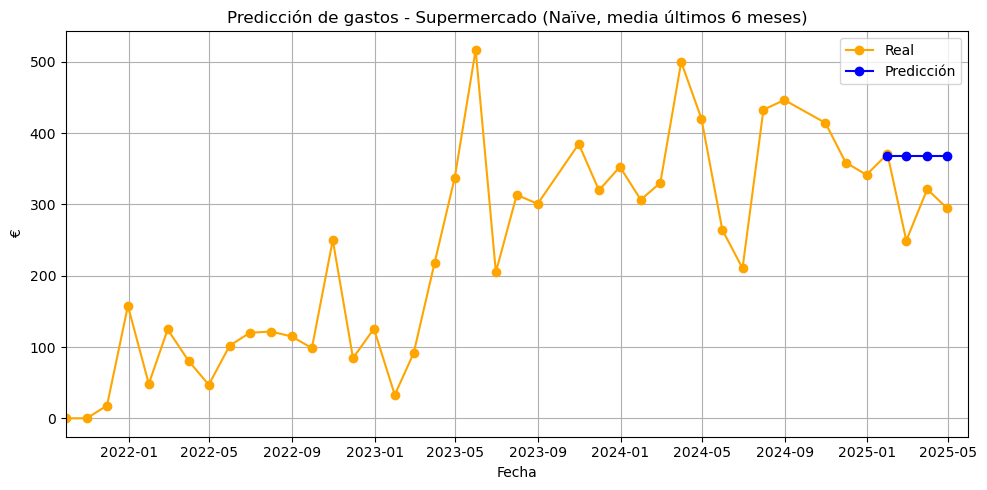

✅ MAE:  60.18 €
✅ RMSE: 73.22 €
✅ MAPE: 21.88 %
✅ R²:   -1.76


,Fecha,Predicción (€),Real (€)
0,2025-01-31,367.4,370.80
1,2025-02-28,367.4,249.23
2,2025-03-31,367.4,321.33
3,2025-04-30,367.4,294.30


In [21]:
modelo_naive_media(gastos_mensuales, 'Supermercado')


,Fecha,Predicción (€),Real (€)
0,2025-01-31,367.4,370.80
1,2025-02-28,367.4,249.23
2,2025-03-31,367.4,321.33
3,2025-04-30,367.4,294.30


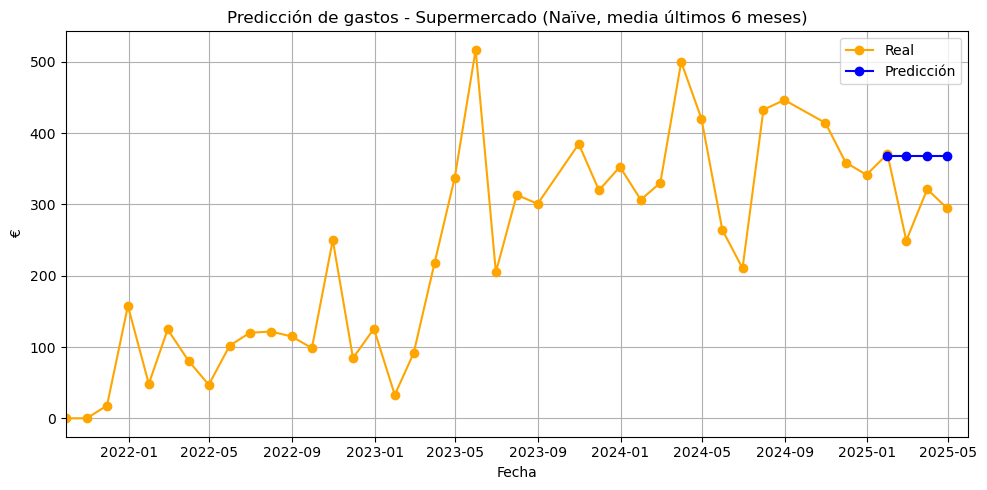

✅ MAE:  60.18 €
✅ RMSE: 73.22 €
✅ MAPE: 21.88 %
✅ R²:   -1.76


,Fecha,Predicción (€),Real (€)
0,2025-01-31,163.62,68.23
1,2025-02-28,163.62,55.99
2,2025-03-31,163.62,52.89
3,2025-04-30,163.62,184.63


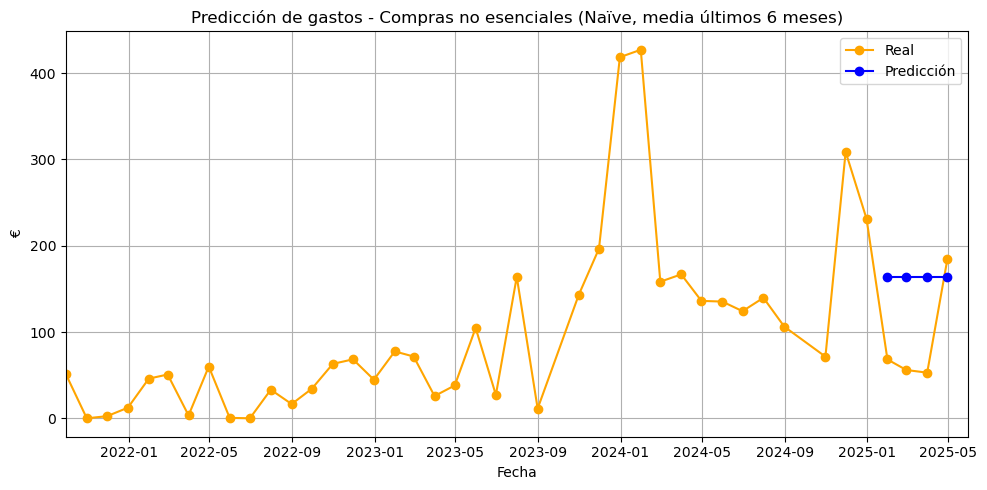

✅ MAE:  83.69 €
✅ RMSE: 91.36 €
✅ MAPE: 138.19 %
✅ R²:   -1.79


,Fecha,Predicción (€),Real (€)
0,2025-01-31,492.56,402.5
1,2025-02-28,492.56,409.0
2,2025-03-31,492.56,688.4
3,2025-04-30,492.56,10.0


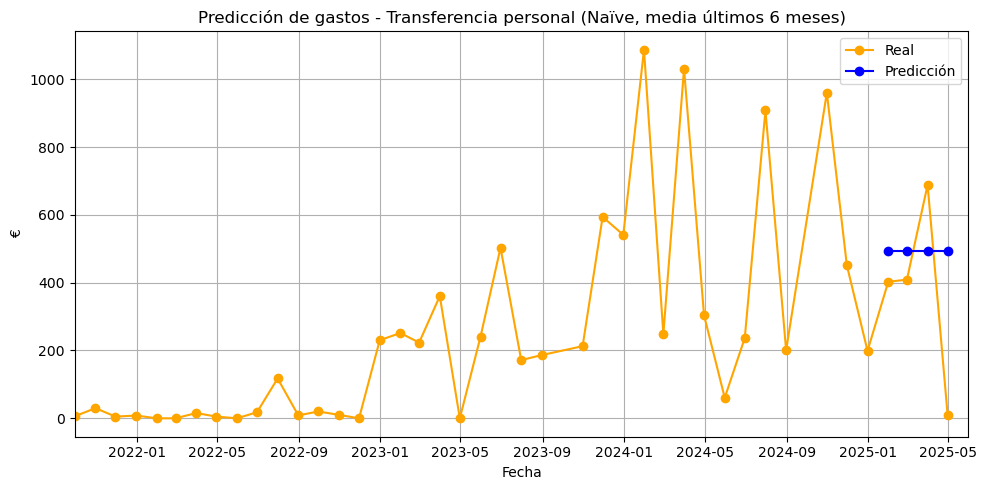

✅ MAE:  213.00 €
✅ RMSE: 267.54 €
✅ MAPE: 1224.21 %
✅ R²:   -0.23


,Fecha,Predicción (€),Real (€)
0,2025-01-31,216.77,314.81
1,2025-02-28,216.77,384.69
2,2025-03-31,216.77,178.20
3,2025-04-30,216.77,178.20


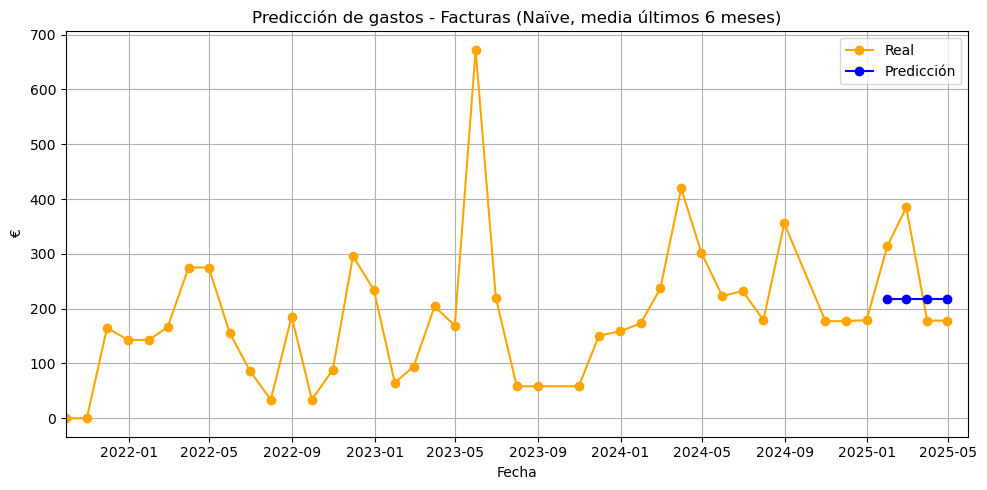

✅ MAE:  85.78 €
✅ RMSE: 100.98 €
✅ MAPE: 29.52 %
✅ R²:   -0.28


,Fecha,Predicción (€),Real (€)
0,2025-01-31,131.46,197.19
1,2025-02-28,131.46,197.19
2,2025-03-31,131.46,0.00
3,2025-04-30,131.46,197.19


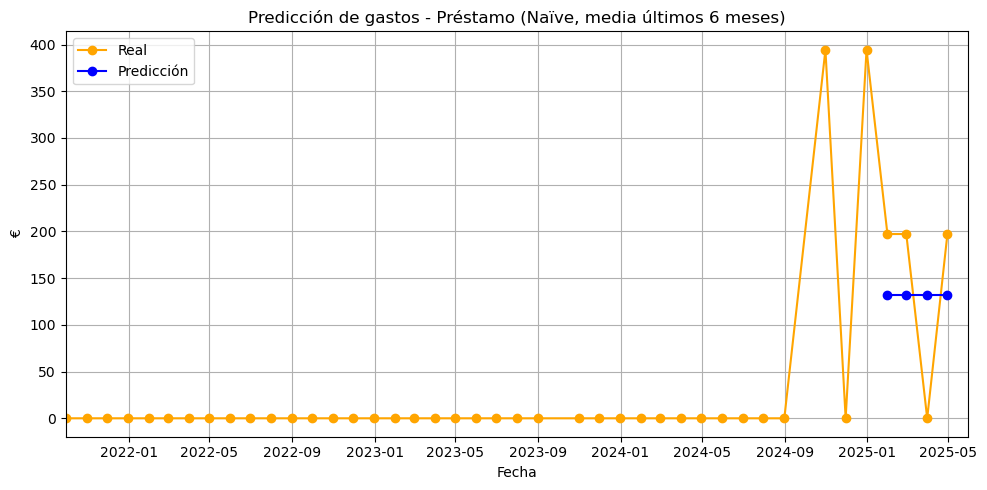

✅ MAE:  82.16 €
✅ RMSE: 86.95 €
✅ MAPE: inf %
✅ R²:   -0.04


,Fecha,Predicción (€),Real (€)
0,2025-01-31,108.75,62.95
1,2025-02-28,108.75,52.96
2,2025-03-31,108.75,52.96
3,2025-04-30,108.75,19.47


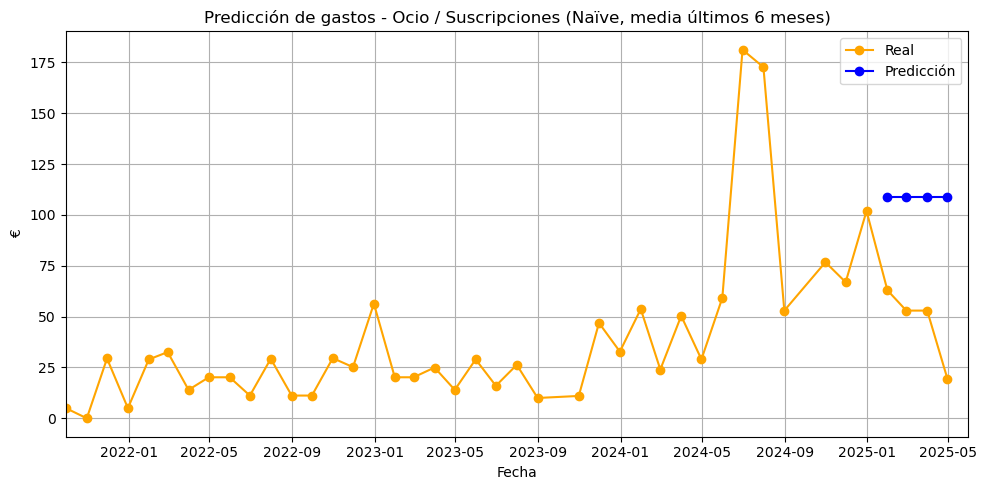

✅ MAE:  61.66 €
✅ RMSE: 63.82 €
✅ MAPE: 185.50 %
✅ R²:   -14.04


,Fecha,Predicción (€),Real (€)
0,2025-01-31,188.19,109.68
1,2025-02-28,188.19,130.40
2,2025-03-31,188.19,241.40
3,2025-04-30,188.19,130.52


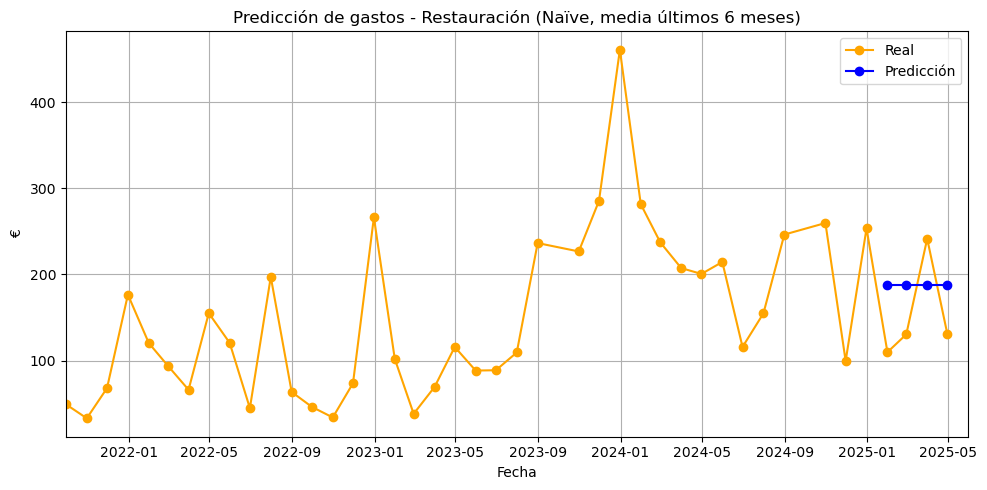

✅ MAE:  61.79 €
✅ RMSE: 62.57 €
✅ MAPE: 45.53 %
✅ R²:   -0.46


,Fecha,Predicción (€),Real (€)
0,2025-01-31,188.19,109.68
1,2025-02-28,188.19,130.40
2,2025-03-31,188.19,241.40
3,2025-04-30,188.19,130.52


In [22]:
modelo_naive_media(gastos_mensuales, 'Supermercado')
modelo_naive_media(gastos_mensuales, 'Compras no esenciales')
modelo_naive_media(gastos_mensuales, 'Transferencia personal')
modelo_naive_media(gastos_mensuales, 'Facturas')
modelo_naive_media(gastos_mensuales, 'Préstamo')
modelo_naive_media(gastos_mensuales, 'Ocio / Suscripciones')
modelo_naive_media(gastos_mensuales, 'Restauración')


# 

In [ ]:
df_categorizado[df_categorizado['categoria'] == 'Préstamo']['importe'].max()


197.19

In [ ]:
df_prestamo = df_categorizado[df_categorizado['categoria'] == 'Préstamo'].copy()
valor_maximo = df_prestamo['importe'].max()
fila_maxima = df_prestamo[df_prestamo['importe'] == valor_maximo]

print(f"Valor máximo: {valor_maximo:.2f} €")
display(fila_maxima[['fecha_operacion', 'importe']])


Valor máximo: 197.19 €


,fecha_operacion,importe
862,2025-04-01,197.19
912,2025-02-28,197.19
951,2025-01-31,197.19
1001,2024-12-31,197.19
1077,2024-12-02,197.19
1132,2024-10-31,197.19
1197,2024-10-01,197.19
2361,2025-03-31,197.19


In [ ]:
"""" Dejar para cuando tenga tiempo"""
# from prophet import Prophet 
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd

# def entrenar_y_predecir_categoria(df_categorizado, categoria, parametros=None):
#     """
#     Entrena un modelo Prophet para una categoría específica y muestra predicción vs. valores reales + métricas.

#     Parámetros:
#     - df_categorizado: DataFrame con las columnas 'fecha_operacion', 'importe', 'categoria'.
#     - categoria: str, nombre de la categoría a analizar.
#     - parametros: dict con hiperparámetros de Prophet. Si es None, se usa el conjunto por defecto.

#     Devuelve:
#     - forecast_2025: DataFrame con las predicciones y valores reales de 2025.
#     """

#     # Filtrar y preparar datos
#     df_cat = df_categorizado[df_categorizado['categoria'] == categoria].copy()
#     df_cat['fecha'] = pd.to_datetime(df_cat['fecha_operacion'])

#     serie_mensual = df_cat.groupby(df_cat['fecha'].dt.to_period('M'))['importe'].sum().reset_index()
#     serie_mensual['fecha'] = serie_mensual['fecha'].dt.to_timestamp()
#     df_prophet = serie_mensual.rename(columns={'fecha': 'ds', 'importe': 'y'})
#     df_prophet['ds'] = df_prophet['ds'] + pd.offsets.MonthEnd(0)

#     # División entrenamiento y prueba
#     df_entrenamiento = df_prophet[df_prophet['ds'] <= '2024-12-31']

#     # Parámetros Prophet
#     if parametros is None:
#         parametros = {
#             'seasonality_mode': 'multiplicative',
#             'changepoint_prior_scale': 0.05,
#             'seasonality_prior_scale': 8.0,
#             'changepoint_range': 0.9,
#             'yearly_seasonality': True,
#             'weekly_seasonality': False,
#             'daily_seasonality': False
#         }

#     modelo = Prophet(**parametros)
#     modelo.fit(df_entrenamiento)
#     futuro = modelo.make_future_dataframe(periods=4, freq='M')
#     forecast = modelo.predict(futuro)

#     # Evaluación en entrenamiento
#     hist = forecast.set_index('ds').loc[df_entrenamiento['ds']]
#     y_pred = hist['yhat']
#     y_true = df_entrenamiento.set_index('ds')['y']
#     mae = mean_absolute_error(y_true, y_pred)
#     print(f"\n📊 Categoría: {categoria}")
#     print(f"✅ MAE entrenamiento (hasta 2024-12): {mae:.2f} €")

#     # Predicción y comparación con datos reales (2025)
#     df_real = df_prophet[df_prophet['ds'] > '2024-12-31']
#     forecast['ds'] = forecast['ds'].dt.to_period('M').dt.to_timestamp()
#     df_real['ds'] = df_real['ds'].dt.to_period('M').dt.to_timestamp()

#     forecast_2025 = forecast[forecast['ds'].isin(df_real['ds'])].copy()
#     forecast_2025 = forecast_2025[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
#     forecast_2025 = forecast_2025.merge(df_real[['ds', 'y']], on='ds', how='left')
#     forecast_2025 = forecast_2025.rename(columns={
#         'ds': 'Fecha',
#         'yhat': 'Predicción (€)',
#         'y': 'Real (€)',
#         'yhat_lower': 'Límite inferior (€)',
#         'yhat_upper': 'Límite superior (€)'
#     }).round(2)

#     # Evaluar predicción 2025 si hay reales
#     if not forecast_2025.empty and forecast_2025['Real (€)'].notna().sum() > 0:
#         y_pred_2025 = forecast_2025['Predicción (€)']
#         y_real_2025 = forecast_2025['Real (€)']
#         mask = ~y_real_2025.isna()

#         mae_2025 = mean_absolute_error(y_real_2025[mask], y_pred_2025[mask])
#         rmse_2025 = np.sqrt(mean_squared_error(y_real_2025[mask], y_pred_2025[mask]))
#         mape_2025 = np.mean(np.abs((y_real_2025[mask] - y_pred_2025[mask]) / y_real_2025[mask])) * 100
#         r2_2025 = r2_score(y_real_2025[mask], y_pred_2025[mask])

#         print(f"✅ MAE para 2025:  {mae_2025:.2f} €")
#         print(f"✅ RMSE para 2025: {rmse_2025:.2f} €")
#         print(f"✅ MAPE para 2025: {mape_2025:.2f} %")
#         print(f"✅ R² para 2025:   {r2_2025:.2f}")

#         display(forecast_2025)
#     else:
#         print("⚠️ No hay datos reales de 2025 para calcular métricas.")
#         display(forecast_2025)

#     # 📈 Gráfico completo desde el inicio
#     plt.figure(figsize=(10, 5))
#     plt.plot(df_prophet['ds'], df_prophet['y'], label='Real', marker='o', color='orange')
#     plt.plot(forecast['ds'], forecast['yhat'], label='Predicción', color='blue')
#     plt.fill_between(forecast['ds'],
#                      forecast['yhat_lower'],
#                      forecast['yhat_upper'],
#                      alpha=0.3, color='blue')
#     plt.title(f"Predicción de gastos - {categoria}")
#     plt.xlabel("Fecha")
#     plt.ylabel("€")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     return forecast_2025

# entrenar_y_predecir_categoria(df_categorizado, 'Supermercado')
# entrenar_y_predecir_categoria(df_categorizado, 'Compras no esenciales')
# entrenar_y_predecir_categoria(df_categorizado, 'Transferencia personal')
# entrenar_y_predecir_categoria(df_categorizado, 'Facturas')
# entrenar_y_predecir_categoria(df_categorizado, 'Préstamo')
# entrenar_y_predecir_categoria(df_categorizado, 'Ocio / Suscripciones')
# entrenar_y_predecir_categoria(df_categorizado, 'Restauración')


'" Dejar para cuando tenga tiempo'